In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from support.imu_calculations import *

In [2]:
_parent_folder = "imu_validationt_march_13_2023"
_folder_name = "test3"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\imu_validationt_march_13_2023'

In [3]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# set zero
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)

_sk_df = set_zero(_sk_df, column_name = ["e_t", "e_rr", "e_rl"])
# rename columns
_sk_df["e_t"] =  -_sk_df["e_t"]

In [4]:
_bosch_df = _sk_df[["time", "ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz"]]
_bosch_df


,time,ax,ay,az,gx,gy,gz,mx,my,mz
0,2023-03-13 14:35:44.561404,-0.712986,0.367858,10.140916,-0.060976,-0.007622,0.030488,381.900024,-124.500008,-51.300003
1,2023-03-13 14:35:44.740838,-0.723155,0.342138,10.156467,-0.060976,-0.015244,0.030488,384.300018,-131.700012,-50.100002
2,2023-03-13 14:35:44.741372,-0.703416,0.336156,10.172618,-0.068598,-0.015244,0.022866,384.300018,-129.300003,-53.100002
3,2023-03-13 14:35:44.741796,-0.712388,0.347521,10.153477,-0.045732,-0.007622,0.015244,384.300018,-131.700012,-51.300003
4,2023-03-13 14:35:44.742322,-0.721360,0.331371,10.152879,-0.068598,-0.007622,0.022866,386.700012,-134.100006,-50.700001
...,...,...,...,...,...,...,...,...,...,...
6001,2023-03-13 14:37:00.290599,-0.713585,0.359484,10.166038,-0.060976,-0.007622,0.022866,384.300018,-131.700012,-50.700001
6002,2023-03-13 14:37:00.303194,-0.700425,0.336755,10.144505,-0.053354,0.000000,0.022866,386.700012,-134.100006,-51.300003
6003,2023-03-13 14:37:00.315732,-0.724949,0.350512,10.152281,-0.076220,0.000000,0.022866,386.700012,-134.100006,-51.900002
6004,2023-03-13 14:37:00.328367,-0.718370,0.354101,10.158262,-0.068598,-0.015244,0.030488,389.100006,-126.900002,-50.100002


c:\Users\CMC\anaconda3\envs\gs\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


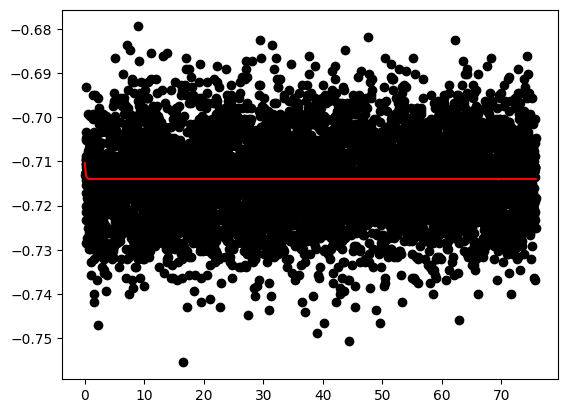

In [9]:
# plt.plot(_bosch_df["time"], _bosch_df["ax"])
# fit a curve
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# time to time stamp
_bosch_df["time"] = _bosch_df["time"].apply(lambda x: (x - _bosch_df["time"].iloc[0]).total_seconds())

xdata = np.array(_bosch_df["time"])
ydata = np.array(_bosch_df["ax"])
popt, pcov = curve_fit(func, xdata, ydata)

plt.plot(xdata, ydata, 'ko', label="Original Noised Data") 
plt.plot(xdata, func(xdata, *popt), 'r-', label="Fitted Curve")

In [8]:
xdata

array(['2023-03-13T14:35:44.561404000', '2023-03-13T14:35:44.740838000',
       '2023-03-13T14:35:44.741372000', ...,
       '2023-03-13T14:37:00.315732000', '2023-03-13T14:37:00.328367000',
       '2023-03-13T14:37:00.340993000'], dtype='datetime64[ns]')